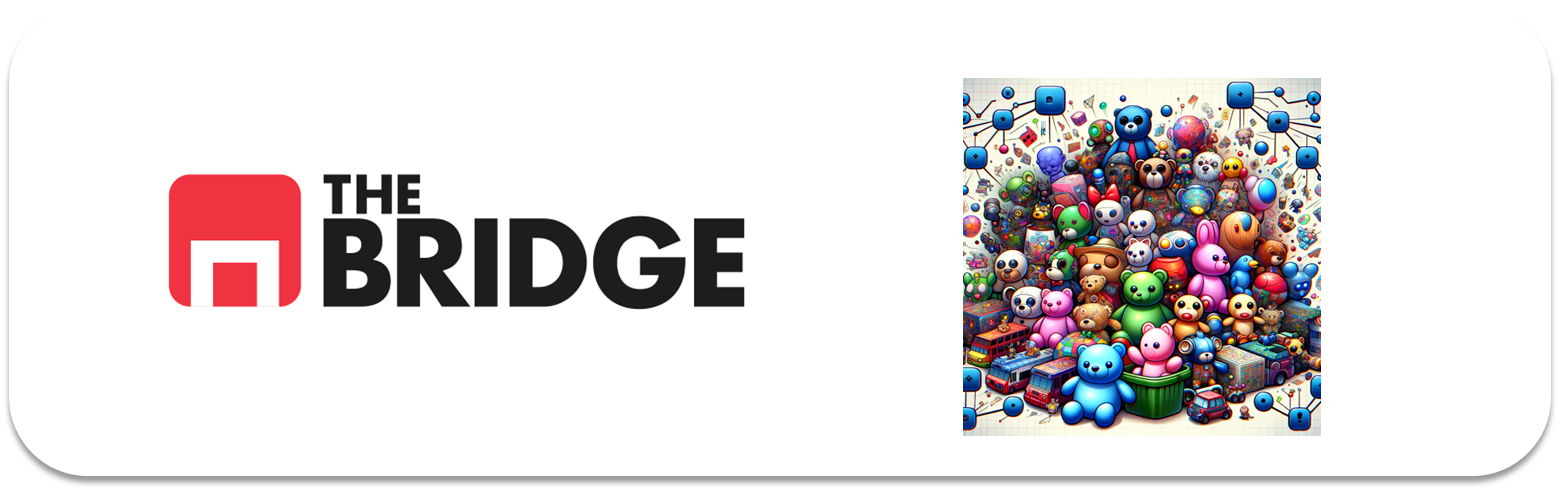

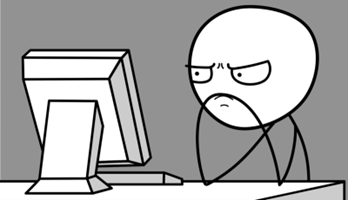

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, ParameterGrid

import warnings
warnings.filterwarnings(action="ignore")

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


1. Entender el problema

Utilizaremos el algoritmo DBSCAN de clustering para segmentar las bebidas energeticas segun la cantidad de componentes en cada bebida.

2. Cargar datos, visualizar

In [2]:
df = pd.read_csv("./data/empowering_drinks.csv", delimiter= '|')

In [3]:
df

Azúcares  Vitamínas del grupo B   Cafeína  Ácido Cítrico   Taurina
0    1.518613               0.232053  1.034819       1.013009  0.251717
1    0.246290              -0.827996  0.733629       0.965242 -0.293321
2    0.196879               1.109334  1.215533       1.395148  0.269020
3    1.691550               0.487926  1.466525       2.334574  1.186068
4    0.295700               1.840403  0.663351      -0.037874 -0.319276
..        ...                    ...       ...            ...       ...
148  0.493343               0.414820 -1.284344       0.009893  0.969783
149  0.332758              -0.389355 -1.344582       0.280575  2.224236
150  0.209232               0.012732 -1.354622       0.296498  1.834923
151  1.395086               1.365208 -1.274305      -0.595160  1.791666
152  0.019564               0.039106 -1.500000       0.081020  0.500000

[153 rows x 5 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


3. MiniEDA: Selección de features

In [5]:
df.describe()

Azúcares  Vitamínas del grupo B     Cafeína  Ácido Cítrico  \
count  153.000000             153.000000  153.000000     153.000000   
mean     0.019231               0.037273    0.041057       0.080022   
std      1.026182               0.995984    1.040928       1.009450   
min     -2.434235              -3.679162   -1.695971      -1.493188   
25%     -0.816038              -0.499016   -1.043392      -0.738463   
50%      0.061000              -0.023821    0.211566      -0.165254   
75%      0.876275               0.707247    0.894264       0.917474   
max      2.259772               3.156325    3.062832       2.971473   

          Taurina  
count  153.000000  
mean    -0.044088  
std      0.934399  
min     -1.634288  
25%     -0.799428  
50%     -0.154899  
75%      0.493956  
max      2.431870

In [6]:
df.hist()
plt.tight_layout()

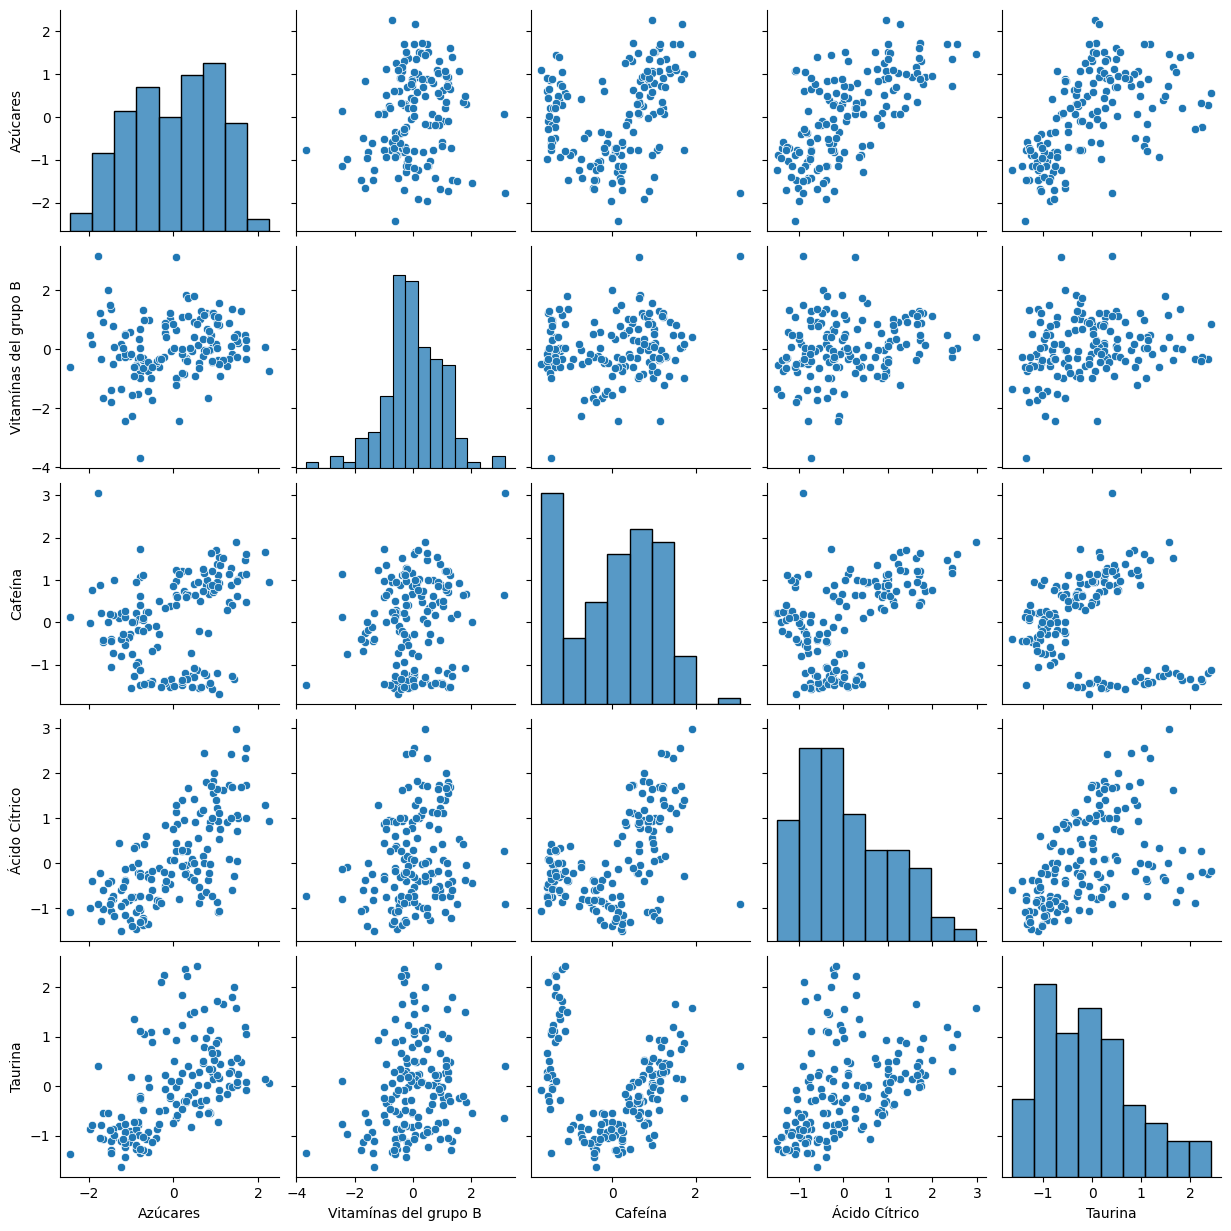

In [7]:
sns.pairplot(df);

4. Tratamiento de Features

In [8]:
features = ['Cafeína', 'Taurina']
X = df[features]

5. Selección de modelos, selección de hiperparámetros

In [16]:
param_grid = {
    'eps': np.arange(0.1, 1.5, 0.1),
    'min_samples': range(3, 6)
}

best_params = None
best_outlier_percentage = float('inf')
best_labels = None

for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    labels = dbscan.fit_predict(X)
    
    percentage_outliers = 100 * np.sum(labels == -1) / len(labels)
    
    # Verificar si es el mejor porcentaje de outliers encontrado
    if percentage_outliers < best_outlier_percentage:
        best_outlier_percentage = percentage_outliers
        best_params = params
        best_labels = labels

print(f"Hiperparámetros DBSCAN: eps={best_params['eps']}, min_samples={best_params['min_samples']}")
print(f"Outliers: {best_outlier_percentage:.2f}%")

Hiperparámetros DBSCAN: eps=0.5, min_samples=3
Outliers: 0.65%


6. Entrenamiento, visualización de resultados

In [17]:
best_k = 5
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(X)
kmeans_labels = kmeans.predict(X)

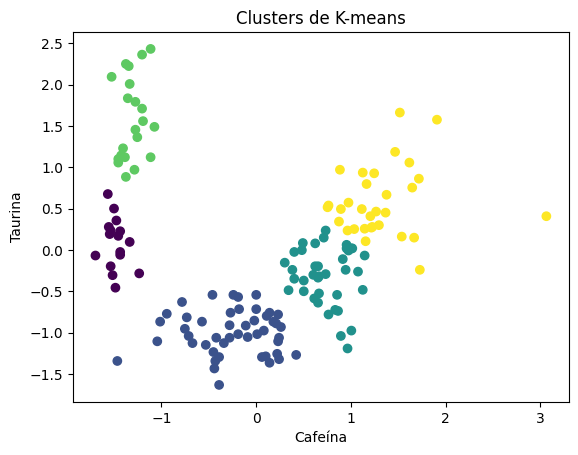

In [18]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=kmeans_labels)
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title('Clusters de K-means')
plt.show()

In [19]:
dbscan = DBSCAN(eps = 0.5, min_samples = 4)
dbscan.fit(X)
dbscan_labels = dbscan.labels_
df['Cluster'] = dbscan_labels

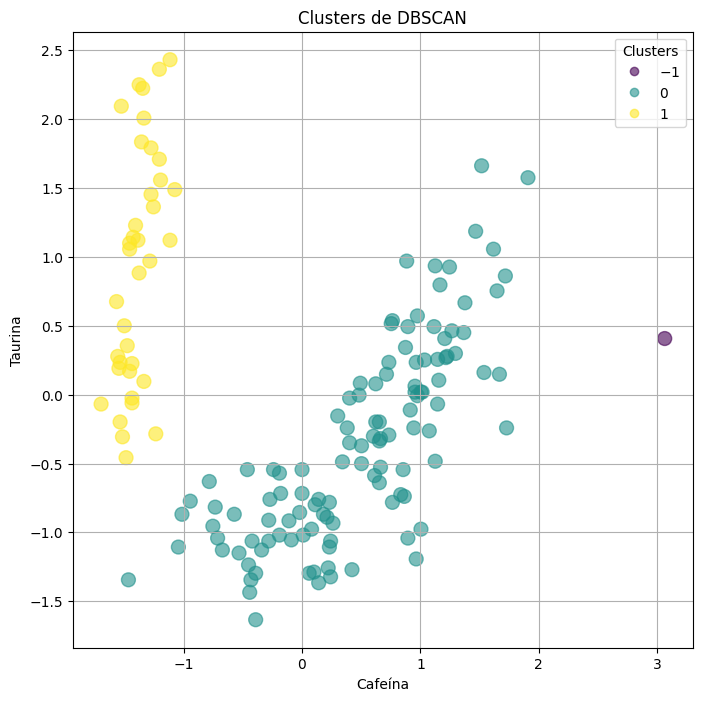

In [20]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=best_labels, s=100, alpha=0.6)
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title('Clusters de DBSCAN')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.show()

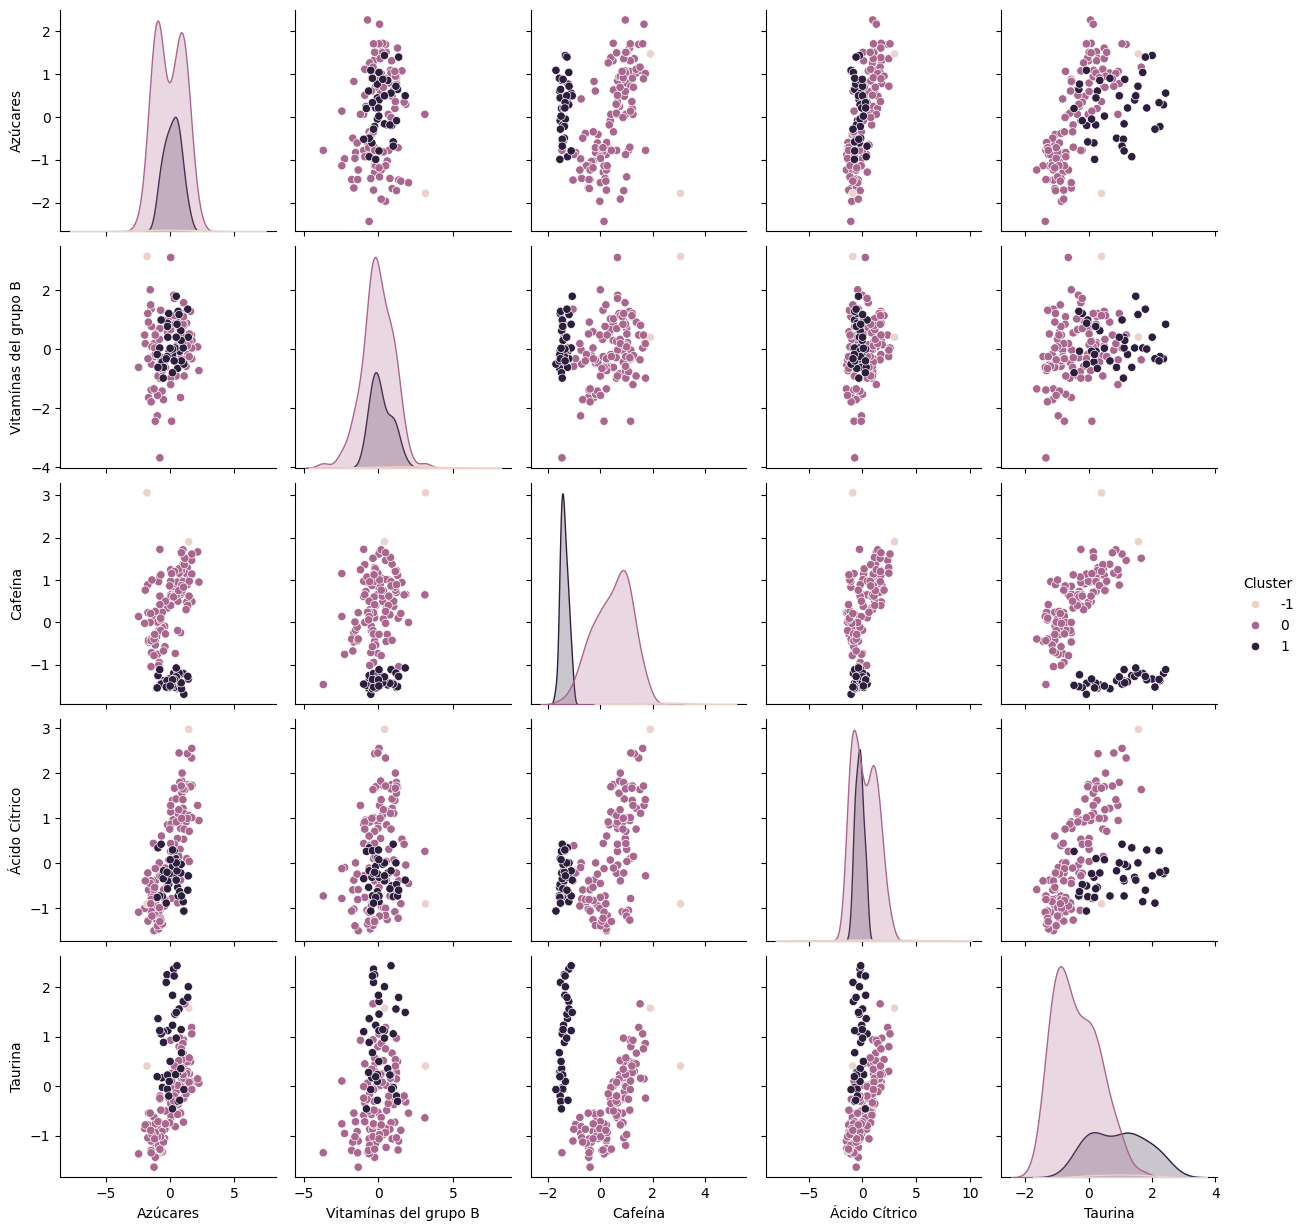

In [22]:
sns.pairplot(df, hue='Cluster');

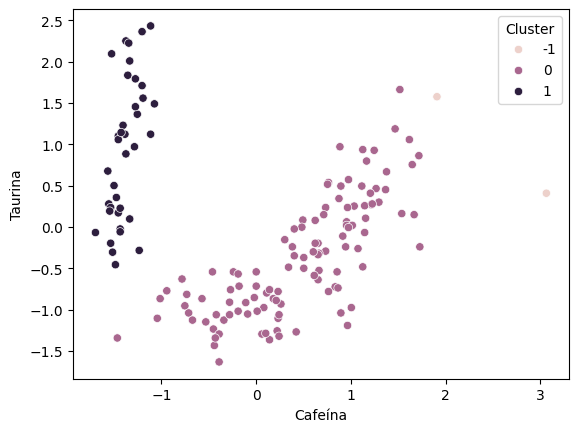

In [24]:
sns.scatterplot(data = df, x = "Cafeína", y = "Taurina", hue = "Cluster");

7. Discusión de los mismos

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.